# Introduction

The following code is based on the publication by Thomas Czypionka, Miriam Reiss and can be found under the link:
https://www.ihs.ac.at/publications-hub/blog/beitraege/infizierte-coronavirus/

As far as we can tell the methodology is identical, while the datasource differs. We pull the data from the Robert Koch Institute, which allows to estimate undetected cases on a federal state and county level.
The results are very sensitive to 3 parameters: 
A country coefficient (a), which describes how many tests are conducted, 
the pace at which the infection spreads (b) and
the delay between a person's infection and the time they show up in the official statistics (c).
Therefore, we computed ensembles with in our opinion reasonable variations in those parameters and use the ensemble mean for the visualization.

The file expModel_Italy.ipynb is a work in progress and shows similar statistics for Italy.

Please note this is a statistical estimate based on the general underlying mathematical properties of viruses and in no way a prediction or offical case count!

Kevin Bachmann and Philipp Holztraeger

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta
from scipy.optimize import curve_fit, fsolve

In [16]:
def logistic_model(x,a,b,c,d):
    return a + (d/(1+np.exp(-(x-c)/b)))

def exponential_model(x,a,b,c):
    #return a*np.exp(b*(x-c))
    return a * b**(x+c)

In [17]:
df = pd.read_csv('../database/data.csv')
df.meldedatum = pd.to_datetime(df.meldedatum)
df['tage'] = df.meldedatum - df.meldedatum.min()

In [20]:
# Can be changed for testing / must be in df.BUNDESLAND.unique()
land='Bayern'

# read in 
df=df.groupby(['bundesland', 'tage']).sum().loc[land].cumsum().resample('1d').ffill().drop('objectid', axis=1)
df = df.reset_index()
df.tage = df.tage / np.timedelta64(1, 'D')

## Visualization of the ensemble of estimates - red line shows observed cases

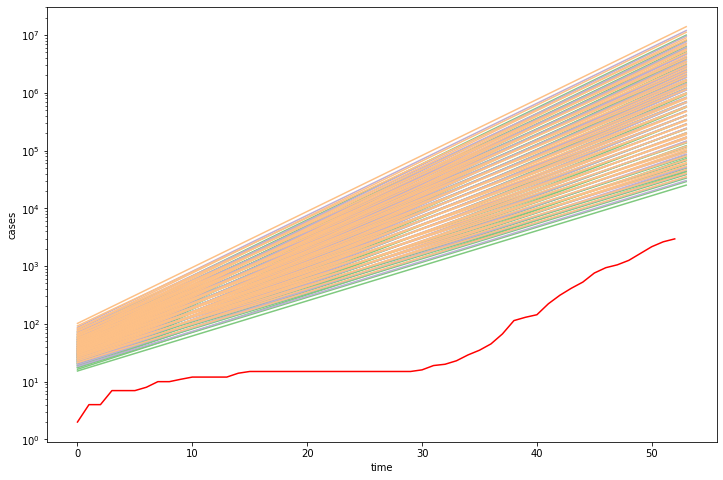

In [22]:
plt.figure(figsize=(12,8))

x = np.linspace(0, len(df.tage), len(df.tage))
color_wheel = ['#7fc97f','#beaed4','#fdc086','#386cb0','#ffff99']

a = df.anzahlfall[0]
country_coef = [2.5,3,3.5]
time_delay   = np.arange(8,13,1)
growth_rate  = np.arange(1.15, 1.25, .01)

adam = np.zeros((len(country_coef), len(time_delay), len(growth_rate), len(df.tage)))

for c, coef in enumerate(country_coef):
    for t, days in enumerate(time_delay):
        for b, rate in enumerate(growth_rate):
            adam[c, t, b, :] = exponential_model(x, coef*a , rate, days)
            plt.plot(x, adam[c, t, b, :], color_wheel[c])

plt.plot(df.tage, df.anzahlfall, 'r', 2, label='Germany')

plt.xlabel('time')
plt.ylabel('cases')
plt.yscale('log')

# Sensitivity to our parameter choices

Text(0, 0.5, 'cases')

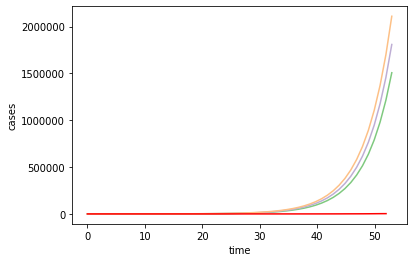

In [28]:
bob = np.mean(adam, axis=(1,2))
for c, coef in enumerate(country_coef):
    plt.plot(x, bob[c, :], color_wheel[c])
            
plt.plot(df.tage, df.anzahlfall, 'r', 2, label='Germany')

plt.xlabel('time')
plt.ylabel('cases')

Text(0, 0.5, 'cases')

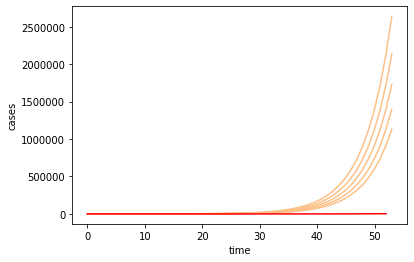

In [29]:
bob = np.mean(adam, axis=(0,2))
for t, days in enumerate(time_delay):
    plt.plot(x, bob[t, :], color_wheel[c])
            
plt.plot(df.tage, df.anzahlfall, 'r', 2, label='Germany')

plt.xlabel('time')
plt.ylabel('cases')

Text(0, 0.5, 'cases')

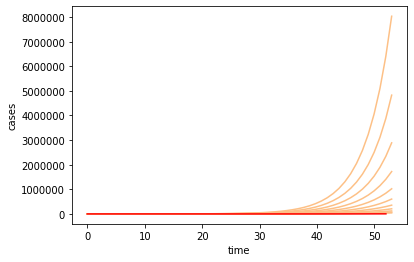

In [30]:
bob = np.mean(adam, axis=(0,1))
for b, rate in enumerate(growth_rate):
    plt.plot(x, bob[b, :], color_wheel[c])

plt.plot(df.tage, df.anzahlfall, 'r', 2, label='Germany')

plt.xlabel('time')
plt.ylabel('cases')

Text(0, 0.5, 'cases')

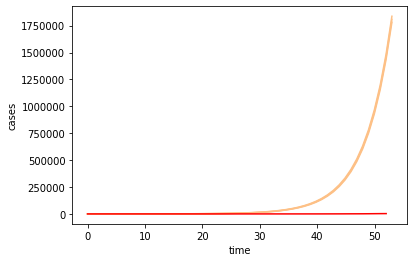

In [31]:
bob = np.mean(adam, axis=(0,1,2))
lb = np.percentile(adam, .25, axis=(0,1,2))
ub = np.percentile(adam, .75, axis=(0,1,2))

plt.plot(x, bob, color_wheel[c])
plt.plot(x, bob - lb, color_wheel[c])
plt.plot(x, bob + ub, color_wheel[c])
    
plt.plot(df.tage, df.anzahlfall, 'r', 2, label='Germany')

plt.xlabel('time')
plt.ylabel('cases')